In [1]:
# '''create new ipython kernel if needed'''
# !python -m ipykernel install --user --name=axonenv
'''check python interpreter path'''
import sys
print(sys.executable)
sys.path.append('/home/adam/MEA_Analysis/AxonReconPipeline')

C:\Users\sravy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import sem, ttest_ind
import statsmodels.stats.multitest as mt
import logging
import ast
import pingouin as pg

color_map = {'MxHEMI': '#0000FF', 'MxWT': '#FF0000', 'FxHET': '#FFA500'}


# Logging setup
#reset logger
import logging
logger = logging.getLogger(__name__)  # Create a logger
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()  # Create handlers, logs to console
#stream_handler.setLevel(logging.DEBUG)  # Set level of handlers
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s - %(module)s.%(funcName)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)  # Add handlers to the logger

In [3]:
#treat data
def count_units_and_branches(data):
    """Count units and branches grouped by DIV and Category."""
    unit_count = 0
    branch_count = 0
    for df in data:
        required_columns = ['DIV', 'Category', 'unit_ids', 'branch_id']
        if not all(column in df.columns for column in required_columns):
            raise ValueError(f"Data must contain the following columns: {required_columns}")
    
        unit_count += len(df['unit_ids'].index)
        branch_counts = [len(eval(branch_list)) for branch_list in df['branch_id']]
        branch_count += sum(branch_counts)

    return unit_count, branch_count

def validate_template_densities(data, threshold=0.95):
    """Validate and filter density data based on given criteria."""
    total_units, total_branches = count_units_and_branches(data)
    print('Unvalidated:')
    print(f'Total units: {total_units}, Total branches: {total_branches}')
    
    valid_data = data.copy()
    for i, df in enumerate(valid_data):
        df['channel_density'] = df['channel_density'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        density_threshold = df['channel_density'].apply(lambda x: x[0]).quantile(threshold)
        valid_df = df[df['channel_density'].apply(lambda x: x[0]) >= density_threshold]
        valid_df.index = range(len(valid_df))  # Reset index
        valid_data[i] = valid_df
    
    valid_units, valid_branches = count_units_and_branches(valid_data)
    print('After density validation:')
    print(f'Total units: {valid_units}, Total branches: {valid_branches}')
    
    return valid_data

def validate_branch_lengths_data(data, stdevs=3):
    """Validate and filter branch lengths data based on given criteria."""
    data_copy = data.copy()
    total_units, total_branches = len(set(data_copy['unit_ids'])), len(data_copy['branch_id'])
    print('Before branch length validation:')
    print(f'Total units: {total_units}, Total branches: {total_branches}')
    
    data_copy['length'] = data_copy['length'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    valid_data = data_copy[data_copy['length'].apply(lambda x: x > 0)]
    valid_data = valid_data[np.abs(valid_data['length'] - valid_data['length'].mean()) <= (stdevs * valid_data['length'].std())]

    valid_units, valid_branches = len(set(valid_data['unit_ids'])), len(valid_data['branch_id'])
    print('After branch length validation:')
    print(f'Total units: {valid_units}, Total branches: {valid_branches}')
    
    return valid_data

def validate_velocity_data(data, stdevs=3):
    """Validate and filter velocity data based on given criteria."""
    data_copy = data.copy()
    total_units, total_branches = len(set(data_copy['unit_ids'])), len(data_copy['branch_id'])
    print('Before velocity validation:')
    print(f'Total units: {total_units}, Total branches: {total_branches}')
    
    data_copy['Velocity'] = data_copy['Velocity'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    valid_data = data_copy[data_copy['Velocity'].apply(lambda x: x > 0)]
    valid_data = valid_data[np.abs(valid_data['Velocity'] - valid_data['Velocity'].mean()) <= (stdevs * valid_data['Velocity'].std())]
    
    valid_units, valid_branches = len(set(valid_data['unit_ids'])), len(valid_data['branch_id'])
    print('After velocity validation:')
    print(f'Total units: {valid_units}, Total branches: {valid_branches}')
    
    return valid_data

def validate_number_of_branches_data(data):
    """Validate and filter number of branches data based on given criteria."""
    data_copy = data.copy()
    total_units, total_branches = len(set(data_copy['unit_ids'])), data_copy['num_branches'].sum()
    print('Before number of branches validation:')
    print(f'Total units: {total_units}, Total branches: {total_branches}')
    
    data_copy['branch_id'] = data_copy['branch_id'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    valid_data = data_copy[data_copy['branch_id'].apply(lambda x: len(x) > 0)]
    
    valid_units, valid_branches = len(set(valid_data['unit_ids'])), valid_data['num_branches'].sum()
    print('After number of branches validation:')
    print(f'Total units: {valid_units}, Total branches: {valid_branches}')
    
    return valid_data

def load_data(file_paths, categories, divs):
    """Load data from CSV files and append category and DIV information."""
    data = []
    for file_path, category, div in zip(file_paths, categories, divs):
        df = pd.read_csv(file_path)
        df['Category'] = category
        df['DIV'] = div
        data.append(df)
    return data

def extract_branch_lengths(data):
    """Extract branch lengths for high-density regions with positive velocities."""
    unit_ids, lengths, categories, DIVs, branch_lists = [], [], [], [], []
    unit_count = 0
    for df in data:
        category, div = df['Category'].iloc[0], df['DIV'].iloc[0]
        for unit_id, length_list, velocity_list, density, branch_list in zip(df['unit_ids'], df['length'], df['velocity'], df['channel_density'], df['branch_id']):
            length_list = eval(length_list)
            branch_lists.extend(eval(branch_list))
            unit_ids.extend([unit_count] * len(length_list))
            lengths.extend(length_list)
            categories.extend([category] * len(length_list))
            DIVs.extend([div] * len(length_list))
            unit_count += 1
    return pd.DataFrame({'unit_ids': unit_ids, 'length': lengths, 'Category': categories, 'DIV': DIVs, 'branch_id': branch_lists})

def extract_branch_velocities(data):
    """Extract branch velocities for high-density regions with positive velocities."""
    unit_ids, velocities, categories, DIVs, branch_lists = [], [], [], [], []
    unit_count = 0
    for df in data:
        category, div = df['Category'].iloc[0], df['DIV'].iloc[0]
        for unit_id, velocity_list, density, branch_list in zip(df['unit_ids'], df['velocity'], df['channel_density'], df['branch_id']):
            velocity_list = eval(velocity_list)
            branch_lists.extend(eval(branch_list))
            unit_ids.extend([unit_count] * len(velocity_list))
            velocities.extend(velocity_list)
            categories.extend([category] * len(velocity_list))
            DIVs.extend([div] * len(velocity_list))
            unit_count += 1
    return pd.DataFrame({'unit_ids': unit_ids, 'Velocity': velocities, 'Category': categories, 'DIV': DIVs, 'branch_id': branch_lists})

def extract_number_of_branches(data):
    """Extract the number of branches with positive velocities for high-density regions."""
    unit_ids, num_branches, branches, categories, DIVs = [], [], [], [], []
    unit_count = 0
    for df in data:
        category, div = df['Category'].iloc[0], df['DIV'].iloc[0]
        for unit_id, branches_list, velocity_list, density in zip(df['unit_ids'], df['branch_id'], df['velocity'], df['channel_density']):
            velocity_list = eval(velocity_list)
            branches_list = eval(branches_list)
            unit_ids.append(unit_count)
            branches.append(branches_list)
            categories.append(category)
            DIVs.append(div)
            num_branches.append(len(branches_list))
            unit_count += 1
    return pd.DataFrame({'unit_ids': unit_ids, 'num_branches': num_branches, 'branch_id': branches, 'Category': categories, 'DIV': DIVs})

def add_significance_annotations(ax, data, y, group_by):
    """Add significance annotations to the plot."""
    divs = data['DIV'].unique()
    pairs, p_values = [], []

    for div in divs:
        data_div = data[data['DIV'] == div]
        categories = data_div[group_by].unique()
        pairs_div = [(cat1, cat2) for i, cat1 in enumerate(categories) for cat2 in categories[i+1:]]
        
        for (cat1, cat2) in pairs_div:
            data1 = data_div[data_div[group_by] == cat1][y]
            data2 = data_div[data_div[group_by] == cat2][y]
            t_stat, p_val = ttest_ind(data1, data2)
            pairs.append((div, cat1, cat2))
            p_values.append(p_val)
            logger.debug(f'Comparing {cat1} vs {cat2} at DIV {div}: t-statistic={t_stat}, p-value={p_val}')

    reject, p_vals_corrected, _, _ = mt.multipletests(p_values, alpha=0.05, method='bonferroni')

    for (div, cat1, cat2), p_val, reject_h0 in zip(pairs, p_vals_corrected, reject):
        if reject_h0:
            x1 = list(divs).index(div)
            y_max = data[data['DIV'] == div][y].max()
            y, h, col = y_max + 1, 1, 'k'
            ax.plot([x1 - 0.2, x1 + 0.2], [y + h, y + h], lw=1.5, c=col)
            ax.text(x1, y + h, "*", ha='center', va='bottom', color=col)
            logger.debug(f'Significant difference between {cat1} and {cat2} at DIV {div} after Bonferroni correction: adjusted p-value={p_val}')

def plot_with_significance(data, y, title, ylabel, scatter=True):
    """Plot data with significance annotations and outliers as diamonds."""
    plt.figure(figsize=(12, 8))
    sorted_data = data[data['Category'].isin(['MxHEMI', 'MxWT', 'FxHET'])].copy()
    sorted_data['Category'] = pd.Categorical(sorted_data['Category'], categories=['MxHEMI', 'MxWT', 'FxHET'], ordered=True)
    
    palette = [color_map[cat] for cat in sorted_data['Category'].cat.categories]
    ax = sns.barplot(x='DIV', y=y, hue='Category', data=sorted_data, palette=palette, alpha=0.6, errorbar='se')
    if scatter: sns.stripplot(x='DIV', y=y, hue='Category', data=sorted_data, jitter=True, dodge=True, marker='D', alpha=0.6, palette=palette, ax=ax, edgecolor='gray')
    
    add_significance_annotations(ax, sorted_data, y, 'Category')
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('DIV')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:3], labels[0:3], title='Category')
    plt.show()

    return ax

# Validate data through all steps and combine filters
def combine_validations(valid_data, stddevs=3):
    branch_lengths_data = extract_branch_lengths(valid_data)
    branch_velocities_data = extract_branch_velocities(valid_data)
    number_of_branches_data = extract_number_of_branches(valid_data)

    valid_bl_data = validate_branch_lengths_data(branch_lengths_data, stdevs=3)
    valid_velocities_data = validate_velocity_data(branch_velocities_data, stdevs=3)
    valid_number_of_branches_data = validate_number_of_branches_data(number_of_branches_data)

    # Merge the validated datasets based on unit_ids
    merged_data = pd.merge(valid_bl_data, valid_velocities_data, on=['unit_ids', 'Category', 'DIV', 'branch_id'])
    #merged_data = pd.merge(merged_data, valid_number_of_branches_data, on=['unit_ids', 'Category', 'DIV', 'branch_id'])
    unit_count, branch_count = len(set(merged_data['unit_ids'])), len(merged_data['branch_id'])
    print('After merging:')
    print(f'Total units: {unit_count}, Total branches: {branch_count}')
    print(f'Number of branches per unit: {branch_count / unit_count}')

    return merged_data

In [4]:
import pandas as pd
import os

'''get current working directory, change it to project root directory'''
os.getcwd()
os.chdir('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis')

# Last Updated 5Aug2024, sg",
# Load the uploaded files into dataframes
files_dict = {
    "DIV5": {
        "T1": { 
            "files": [
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well000_axon_analytics_dvdt.csv', "MxHEMI"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well001_axon_analytics_dvdt.csv', "MxWT"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well002_axon_analytics_dvdt.csv', "FxHET"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well003_axon_analytics_dvdt.csv', "MxHEMI"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well004_axon_analytics_dvdt.csv', "MxWT"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well005_axon_analytics_dvdt.csv', "FxHET"),
            ]
        }
    },
    #"DIV8": {
    #    "T1": {
    #        "files": [
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well001_axon_analytics_dvdt.csv', "MxWT"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well002_axon_analytics_dvdt.csv', "FxHET"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well003_axon_analytics_dvdt.csv', "MxHEMI"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well004_axon_analytics_dvdt.csv', "MxWT"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well005_axon_analytics_dvdt.csv', "FxHET"),
    #        ]
    #    }
    #},
    #"DIV8": {
    #    "T1": {
    #        "files": [
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well000_axon_analytics_dvdt.csv', "MxHEMI"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well001_axon_analytics_dvdt.csv', "MxWT"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well002_axon_analytics_dvdt.csv', "FxHET"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well003_axon_analytics_dvdt.csv', "MxHEMI"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well004_axon_analytics_dvdt.csv', "MxWT"),
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well005_axon_analytics_dvdt.csv', "FxHET"),
    #        ]
    #    }
    #},
    "DIV8": {
        "T1": {
            "files": [
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well000_axon_analytics_dvdt.csv', "MxHEMI"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well001_axon_analytics_dvdt.csv', "MxWT"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well002_axon_analytics_dvdt.csv', "FxHET"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well003_axon_analytics_dvdt.csv', "MxHEMI"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well004_axon_analytics_dvdt.csv', "MxWT"),
                ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well005_axon_analytics_dvdt.csv', "FxHET"),
            ]
        }
    }
    #"DIV30": {
    #    "T1": {
    #        #TODO: Note why there are missing data here.
    #        "files": [
    #            ('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240614_M08018_000128_AxonTracking_well000_axon_analytics_dvdt.csv', "MxHEMI"),
    #        ]
    #    }
    #},
}


In [5]:

file_paths = []
categories = []
divs = []

for div, div_data in files_dict.items():
    for t, t_data in div_data.items():
        for file_path, category in t_data["files"]:
            file_paths.append(file_path)
            categories.append(category)
            divs.append(int(div[3:]))  # Extract the DIV number

# Verify files exist
for file in file_paths:
    try:
        assert os.path.exists(file), f"File {file} does not exist"
    except Exception as e:
        print(e)
        pass

try: assert len(categories) == len(divs) == len(categories), "Length of categories and DIVs must be equal to the number of files"
except AssertionError as e: 
    print(e)
    print(len(categories), len(divs), len(file_paths))

#Modify lists to exclude data based on position in categories
#categories = [categories[i] for i in range(len(categories)) if categories[i] != 'HOM']
#categories = [categories[i] for i in range(len(categories)) if categories[i] != 'HET']
#categories = [categories[i] for i in range(len(categories)) if categories[i] != 'WT']

In [6]:
# Load data with the given categories and DIVs
#from AxonReconPipeline.src.lib_plotting_and_analysis import load_data
#from AxonReconPipeline.src.lib_plot_and_analyze import load_data
data = load_data(file_paths, categories, divs)

In [7]:
# from AxonReconPipeline.src.lib_plotting_and_analysis import extract_branch_lengths, extract_branch_velocities, extract_number_of_branches
# from AxonReconPipeline.src.lib_plotting_and_analysis import (
#     validate_template_densities, 
#     #validate_branch_lengths_data, 
#     #validate_velocity_data,
#     #validate_number_of_branches_data,
#     count_all_units_and_branches,
# )

#template validation
valid_data = validate_template_densities(data, threshold=0.75) #Arbitrary number. #TODO: Find a good threshold

# Extract data
branch_lengths_data = extract_branch_lengths(valid_data)
branch_velocities_data = extract_branch_velocities(valid_data)
#number_of_branches_data = extract_number_of_branches(valid_data)

#validate data
final_valid_data = combine_validations(valid_data, stddevs=4)

Unvalidated:
Total units: 246, Total branches: 830
After density validation:
Total units: 74, Total branches: 144
Before branch length validation:
Total units: 74, Total branches: 144
After branch length validation:
Total units: 74, Total branches: 142
Before velocity validation:
Total units: 74, Total branches: 144
After velocity validation:
Total units: 73, Total branches: 139
Before number of branches validation:
Total units: 74, Total branches: 144
After number of branches validation:
Total units: 74, Total branches: 144
After merging:
Total units: 73, Total branches: 138
Number of branches per unit: 1.8904109589041096


C:\Users\sravy\AppData\Local\Temp\ipykernel_19308\1693222164.py:183: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  if scatter: sns.stripplot(x='DIV', y=y, hue='Category', data=sorted_data, jitter=True, dodge=True, marker='D', alpha=0.6, palette=palette, ax=ax, edgecolor='gray')
2024-08-05 17:58:14,938 - DEBUG - Comparing MxHEMI vs MxWT at DIV 5: t-statistic=-0.10529362491205731, p-value=0.917142085241571 - 1693222164.add_significance_annotations
2024-08-05 17:58:14,947 - DEBUG - Comparing MxHEMI vs FxHET at DIV 5: t-statistic=0.22415458243043568, p-value=0.8250297946950063 - 1693222164.add_significance_annotations
2024-08-05 17:58:14,957 - DEBUG - Comparing MxWT vs FxHET at DIV 5: t-statistic=0.3428513806006372, p-value=0.7352875649592677 - 1693222164.add_significance_annotations
2024-08-05 17:58:14,970 - DEBUG - Comparing MxHEMI vs MxWT at DIV 8: t-statistic=-2.20363378637678, p-value=0.031155107945830846 -

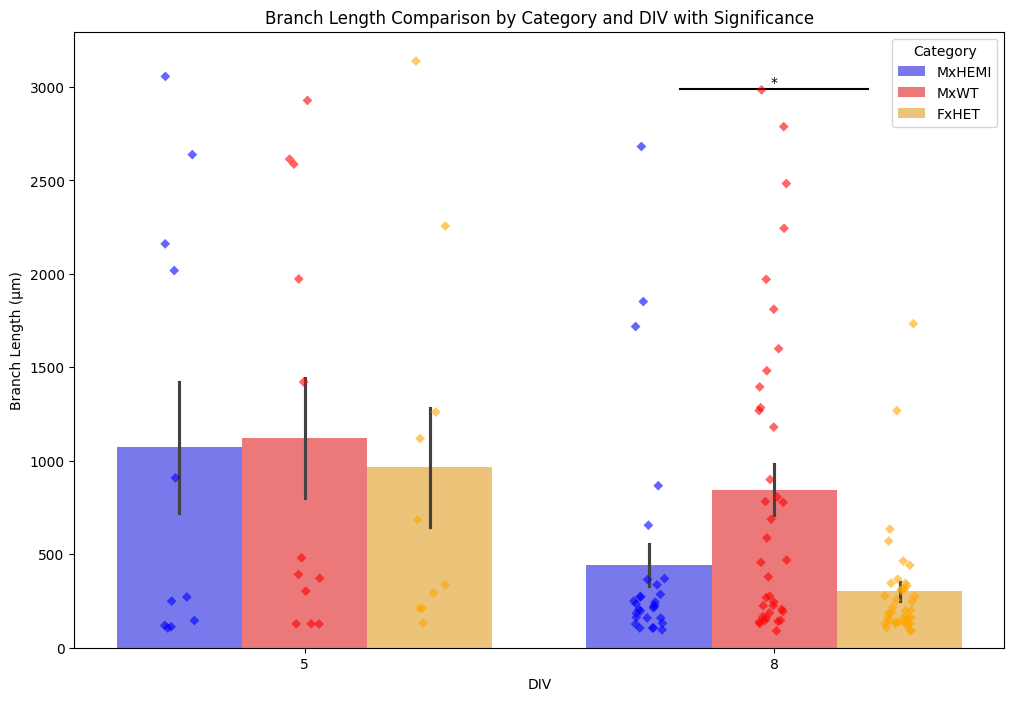

2024-08-05 17:58:15,862 - DEBUG - Comparing MxHEMI vs MxWT at DIV 5: t-statistic=-0.10529362491205731, p-value=0.917142085241571 - 1693222164.add_significance_annotations
2024-08-05 17:58:15,875 - DEBUG - Comparing MxHEMI vs FxHET at DIV 5: t-statistic=0.22415458243043568, p-value=0.8250297946950063 - 1693222164.add_significance_annotations
2024-08-05 17:58:15,890 - DEBUG - Comparing MxWT vs FxHET at DIV 5: t-statistic=0.3428513806006372, p-value=0.7352875649592677 - 1693222164.add_significance_annotations
2024-08-05 17:58:15,906 - DEBUG - Comparing MxHEMI vs MxWT at DIV 8: t-statistic=-2.20363378637678, p-value=0.031155107945830846 - 1693222164.add_significance_annotations
2024-08-05 17:58:15,921 - DEBUG - Comparing MxHEMI vs FxHET at DIV 8: t-statistic=1.2348173154667836, p-value=0.22127662729223516 - 1693222164.add_significance_annotations
2024-08-05 17:58:15,937 - DEBUG - Comparing MxWT vs FxHET at DIV 8: t-statistic=3.824070735857726, p-value=0.00027169799133190675 - 1693222164.ad

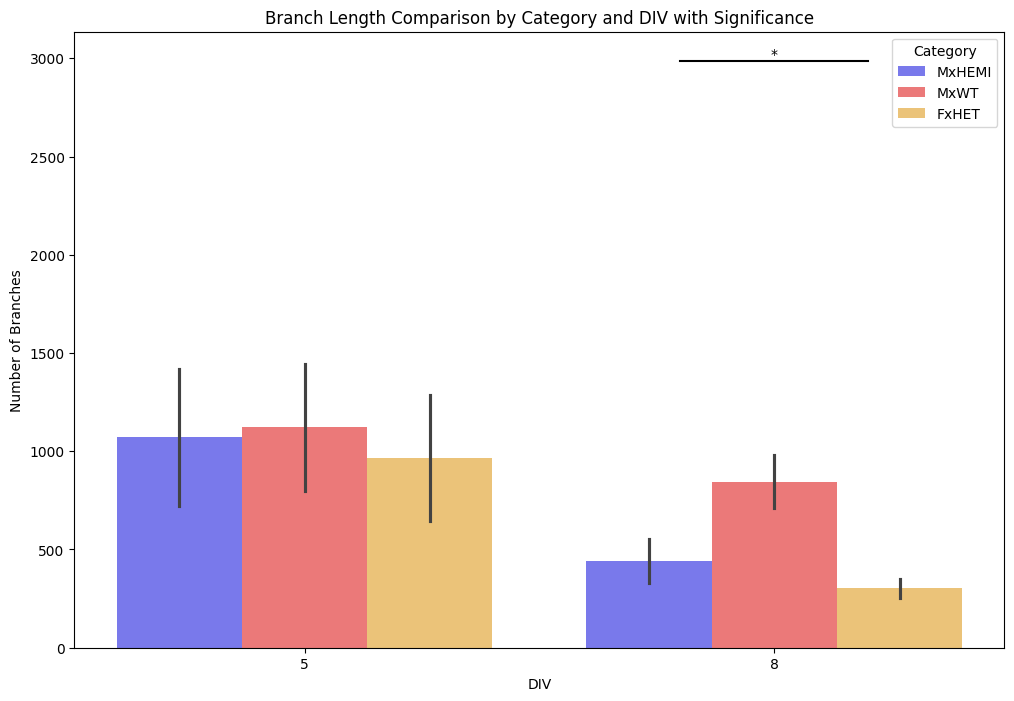

C:\Users\sravy\AppData\Local\Temp\ipykernel_19308\1693222164.py:183: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  if scatter: sns.stripplot(x='DIV', y=y, hue='Category', data=sorted_data, jitter=True, dodge=True, marker='D', alpha=0.6, palette=palette, ax=ax, edgecolor='gray')
2024-08-05 17:58:16,682 - DEBUG - Comparing MxHEMI vs MxWT at DIV 5: t-statistic=0.14853640095134854, p-value=0.8833365511584284 - 1693222164.add_significance_annotations
2024-08-05 17:58:16,688 - DEBUG - Comparing MxHEMI vs FxHET at DIV 5: t-statistic=1.2166687711810111, p-value=0.2386285681537377 - 1693222164.add_significance_annotations
2024-08-05 17:58:16,698 - DEBUG - Comparing MxWT vs FxHET at DIV 5: t-statistic=1.2891911340136066, p-value=0.2120432563116152 - 1693222164.add_significance_annotations
2024-08-05 17:58:16,707 - DEBUG - Comparing MxHEMI vs MxWT at DIV 8: t-statistic=1.735790741541907, p-value=0.08741334530320018 - 1

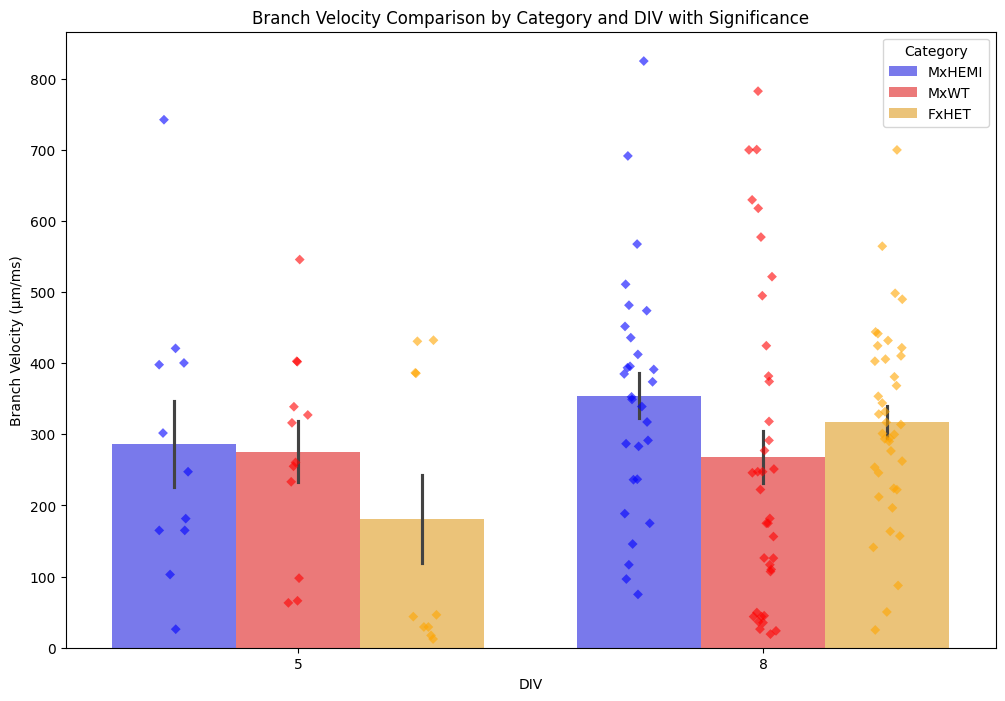

2024-08-05 17:58:17,311 - DEBUG - Comparing MxHEMI vs MxWT at DIV 5: t-statistic=0.14853640095134854, p-value=0.8833365511584284 - 1693222164.add_significance_annotations
2024-08-05 17:58:17,316 - DEBUG - Comparing MxHEMI vs FxHET at DIV 5: t-statistic=1.2166687711810111, p-value=0.2386285681537377 - 1693222164.add_significance_annotations
2024-08-05 17:58:17,324 - DEBUG - Comparing MxWT vs FxHET at DIV 5: t-statistic=1.2891911340136066, p-value=0.2120432563116152 - 1693222164.add_significance_annotations
2024-08-05 17:58:17,335 - DEBUG - Comparing MxHEMI vs MxWT at DIV 8: t-statistic=1.735790741541907, p-value=0.08741334530320018 - 1693222164.add_significance_annotations
2024-08-05 17:58:17,341 - DEBUG - Comparing MxHEMI vs FxHET at DIV 8: t-statistic=0.9992986537632059, p-value=0.3212997823412963 - 1693222164.add_significance_annotations
2024-08-05 17:58:17,348 - DEBUG - Comparing MxWT vs FxHET at DIV 8: t-statistic=-1.1712633589257988, p-value=0.2452505765942193 - 1693222164.add_sig

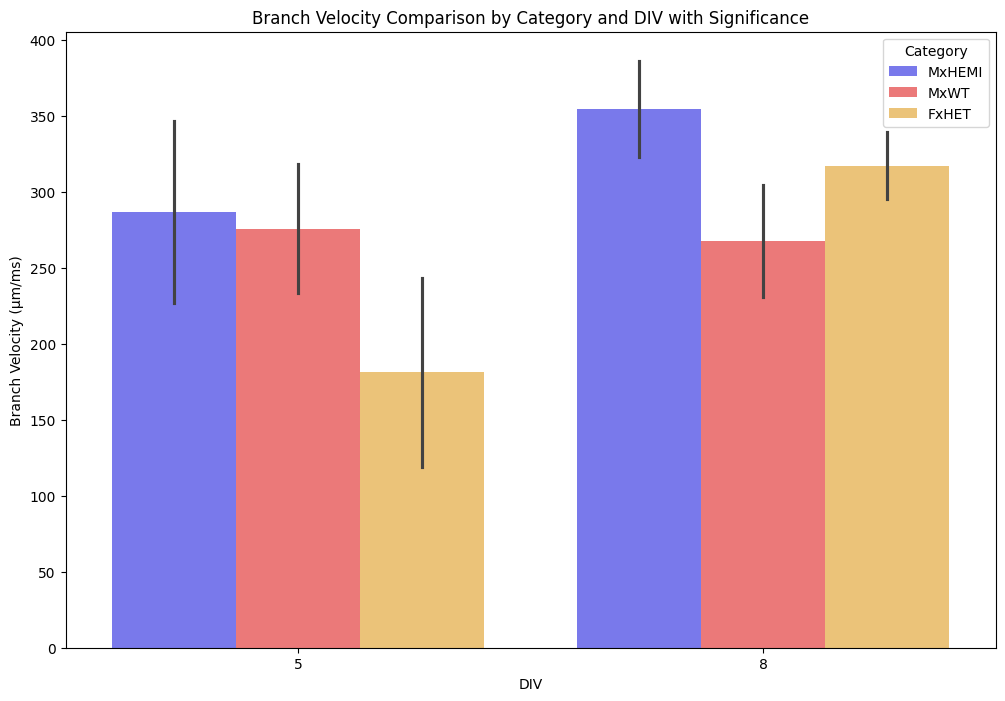

In [8]:
#from AxonReconPipeline.src.lib_plotting_and_analysis import plot_with_significance
# from AxonReconPipeline.src.lib_plotting_and_analysis import validate_branch_lengths_data, validate_branch_velocities_data, validate_number_of_branches_data
#from AxonReconPipeline.src.lib_plot_and_analyze import plot_velocities_by_gene

# Plot data with significance annotations
ax = plot_with_significance(final_valid_data, 'length', 'Branch Length Comparison by Category and DIV with Significance', 'Branch Length (µm)')
ax.get_figure().savefig('branch_length_comparison.svg', format='svg')
ax = plot_with_significance(final_valid_data, 'length', 'Branch Length Comparison by Category and DIV with Significance', 'Number of Branches', scatter=False)
ax.get_figure().savefig('branch_length_comparison_noscatter.svg', format='svg')

ax = plot_with_significance(final_valid_data, 'Velocity', 'Branch Velocity Comparison by Category and DIV with Significance', 'Branch Velocity (µm/ms)')
ax.get_figure().savefig('branch_velocity_comparison.svg', format='svg') 
ax = plot_with_significance(final_valid_data, 'Velocity', 'Branch Velocity Comparison by Category and DIV with Significance', 'Branch Velocity (µm/ms)', scatter=False)
ax.get_figure().savefig('branch_velocity_comparison_noscatter.svg', format='svg') 

In [9]:
'''Select axon analytic .csv files to plot/compare'''

import pandas as pd
import os

'''get current working directory, change it to project root directory'''
os.getcwd()
os.chdir('C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis')

# Load the uploaded files into dataframes
file_paths = [

#DIV5
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well000_axon_analytics_template.csv', # DIV 5, MxHEMI 
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well001_axon_analytics_template.csv', # DIV 5, MxWT
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well002_axon_analytics_template.csv', # DIV 5, FxHET
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well003_axon_analytics_template.csv', # DIV 5, MxHEMI
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well004_axon_analytics_template.csv', # DIV 5, MxWT
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240520_M08018_000014_AxonTracking_well005_axon_analytics_template.csv', # DIV 5, FxHET


#DIV8
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well001_axon_analytics_template.csv', # MxWT
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well002_axon_analytics_template.csv', # FxHET
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well003_axon_analytics_template.csv', # MxHEMI
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well004_axon_analytics_template.csv', # MxWT
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000029_AxonTracking_well005_axon_analytics_template.csv', # FxHET

#DIV8
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well000_axon_analytics_template.csv', # MxHEMI
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well001_axon_analytics_template.csv', # MxWT
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well002_axon_analytics_template.csv', # FxHET
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well003_axon_analytics_template.csv', # MxHEMI
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well004_axon_analytics_template.csv', # MxWT
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000031_AxonTracking_well005_axon_analytics_template.csv', # FxHET

#DIV8
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well000_axon_analytics_template.csv', # MxHEMI
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well001_axon_analytics_template.csv', # MxWT
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well002_axon_analytics_template.csv', # FxHET
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well003_axon_analytics_template.csv', # MxHEMI
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well004_axon_analytics_template.csv', # MxWT
'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240523_M08018_000037_AxonTracking_well005_axon_analytics_template.csv', # FxHET

#DIV30
#'C:/Users/sravy/OneDrive/Documents/MEA_Analysis/MEA_Analysis/AxonReconPipeline/data_csvs/reconstructions_CDKL5_E6D_T1_C1_05152024/240614_M08018_000128_AxonTracking_well000_axon_analytics_template.csv', # MxHEMI
]

# Define corresponding categories and DIVs
# categories = ['HET', 'WT', 'HET', 'WT', 'HET', 'WT', 'HET', 'WT','HET', 'WT']
# divs = [10, 10, 10, 10, 13, 13, 13, 13, 16, 16]
# assert len(categories) == len(divs), "Number of categories and file paths must match"

# Load data with the given categories and DIVs
from AxonReconPipeline.src.lib_plotting_and_analysis import load_data
data = load_data(file_paths, categories, divs)

In [10]:
from AxonReconPipeline.src.lib_plotting_and_analysis import extract_branch_lengths, extract_branch_velocities, extract_number_of_branches
# Extract data
branch_lengths_data = extract_branch_lengths(data)
branch_velocities_data = extract_branch_velocities(data)
number_of_branches_data = extract_number_of_branches(data)




ZeroDivisionError: float division by zero

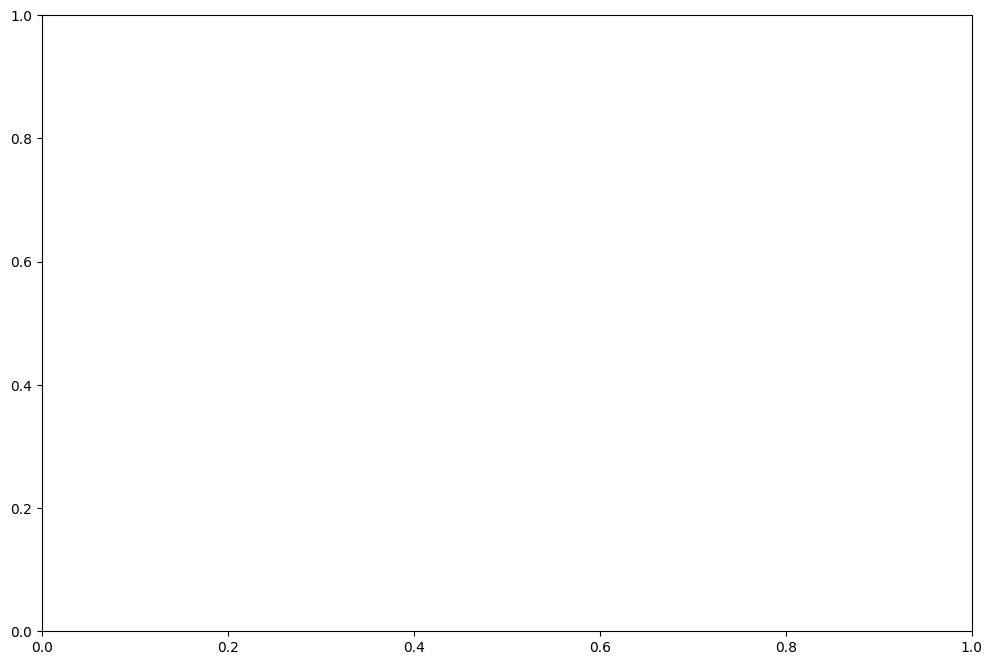

In [11]:
from AxonReconPipeline.src.lib_plotting_and_analysis import plot_with_significance
# Plot data with significance annotations
plot_with_significance(branch_lengths_data, 'Length', 'Branch Length Comparison by Category and DIV with Significance', 'Branch Length (µm)')
#plot_with_significance(number_of_branches_data, 'Branches', 'Number of Branches Comparison by Category and DIV with Significance', 'Number of Branches')
plot_with_significance(branch_velocities_data, 'Velocity', 'Branch Velocity Comparison by Category and DIV with Significance', 'Branch Velocity (µm/ms)')

from AxonReconPipeline.src.lib_plotting_and_analysis import count_units_and_branches
unit_counts_branches, branch_counts_branches = count_units_and_branches(number_of_branches_data)
print(f"Unit counts: {unit_counts_branches}")
print(f"Branch counts: {branch_counts_branches}")